In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import pickle

In [2]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [4]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [5]:
colors = mpl.cm.get_cmap("tab20").colors

In [6]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30

### Load coverage

In [7]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [8]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [9]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [10]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [11]:
clust["snps_to_clusters"].shape

(500, 11768)

In [12]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single allelic DP iteration

In [13]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [14]:
min_tots = np.zeros(clust_uj.max() + 1)
maj_tots = np.zeros(clust_uj.max() + 1)
clusts= clust_uj[499]
phases = clust["snps_to_phases"][499]
SNPs2 = SNPs.copy()
SNPs2.iloc[phases, [0, 1]] = SNPs2.iloc[phases, [1, 0]]

maj_tots += npg.aggregate(clusts, SNPs2["maj"], size = clust_uj.max() + 1)
min_tots += npg.aggregate(clusts, SNPs2["min"], size = clust_uj.max() + 1)

min_tots /= clust_uj.shape[0]
maj_tots /= clust_uj.shape[0]

min_tots = min_tots[np.flatnonzero(prune_idx)]
maj_tots = maj_tots[np.flatnonzero(prune_idx)]

In [15]:
f_prune = (min_tots/(min_tots + maj_tots))

In [16]:
with open('./exome_results/Cov_DP_model.pickle', 'rb') as f:
    dp_pickle = pickle.load(f)

In [19]:
dp_pickle.DP_runs[0].cov_df.groupby(['allelic_cluster', 'cov_DP_cluster']).indices)

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID
99,1,984246,984439,72279,110383,984246,984439,194,1.079453,1.880682,0.685567,0.269813,3,32
135,1,1138970,1139348,185857,281995,1138970,1139348,379,0.909914,0.588950,0.704485,0.291114,0,0
142,1,1147321,1147518,78285,120449,1147321,1147518,198,0.909914,0.588950,0.707071,0.293980,3,32
344,1,1469305,1469452,36846,57636,1469305,1469452,148,0.870065,0.250387,0.668919,0.250576,8,87
514,1,1956956,1957177,69400,108383,1956956,1957177,222,1.002400,1.320789,0.621622,0.193192,3,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196523,22,50986595,50988380,977681,1456772,2880715315,2880717100,1786,0.954171,0.948001,0.693729,0.279074,0,4
196531,22,51009803,51009968,59148,93244,2880738523,2880738688,166,1.022385,1.470038,0.602410,0.168626,0,4
196560,22,51042269,51043492,635932,981591,2880770989,2880772212,1224,1.060847,1.749233,0.744281,0.334114,0,4
196569,22,51064006,51064109,40385,64456,2880792726,2880792829,104,1.060847,1.749233,0.576923,0.134799,0,4


In [25]:
def create_seg_df_tuple_specific(dp_pickle, SNPs2):
    global_seg_counter = 0
    draw_dfs = []

    for draw_num, dp_run in enumerate(dp_pickle.DP_runs):
        print('concatenating dp run ', draw_num)
        a_cov_seg_df = dp_run.cov_df.copy()

        # add minor and major allele counts for each bin to the cov_seg_df here to allow for beta draws on the fly for each segment
        a_cov_seg_df['min_count'] = 0
        a_cov_seg_df['maj_count'] = 0
        min_col_idx = a_cov_seg_df.columns.get_loc('min_count')
        maj_col_idx = a_cov_seg_df.columns.get_loc('maj_count')

        SNPs2["cov_tidx"] = mut.map_mutations_to_targets(SNPs2, a_cov_seg_df, inplace=False)

        for idx, group in SNPs2.groupby('cov_tidx').indices.items():
            minor, major = SNPs2.iloc[group, [0, 1]].sum()
            a_cov_seg_df.iloc[int(idx), [min_col_idx, maj_col_idx]] = minor, major

        # add dp cluster annotations
        a_cov_seg_df['cov_DP_cluster'] = -1
        
        segs_to_clusts = dp_run.bins_to_clusters[-1]
        for s in range(len(segs_to_clusts)):
            a_cov_seg_df.loc[a_cov_seg_df['segment_ID'] == s, 'cov_DP_cluster'] = segs_to_clusts[s]

        # adding cluster mus and sigmas to df
        a_cov_seg_df['cov_DP_mu'] = 0
        a_cov_seg_df['cov_DP_sigma'] = 0
        
        for adp, cdp in a_cov_seg_df.groupby(['allelic_cluster', 'cov_DP_cluster']).indices:
            acdp_clust = a_cov_seg_df.loc[(a_cov_seg_df.cov_DP_cluster == cdp) & (a_cov_seg_df.allelic_cluster == adp)]
            if len(acdp_clust) < 10:
                acdp_clust = a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == cdp]
            r = acdp_clust.covcorr.values
            C = np.c_[np.log(acdp_clust['C_len'].values), acdp_clust['C_RT_z'].values, acdp_clust['C_GC_z'].values]
            endog = np.exp(np.log(r) - (C @ dp_pickle.beta).flatten())
            exog = np.ones(r.shape)
            sNB = statsNB(endog, exog)
            res = sNB.fit(disp=0)
            mu = res.params[0]
            a_cov_seg_df.loc[(a_cov_seg_df.cov_DP_cluster == cdp) & (a_cov_seg_df.allelic_cluster == adp), 'cov_DP_mu'] = mu
            H = sNB.hessian(res.params)
            mu_sigma = np.linalg.inv(-H)[0, 0]
            a_cov_seg_df.loc[(a_cov_seg_df.cov_DP_cluster == cdp) & (a_cov_seg_df.allelic_cluster == adp), 'cov_DP_sigma'] = mu_sigma
            
        
        #add next_g for ease of plotting down the line
        a_cov_seg_df["next_g"] = np.r_[a_cov_seg_df.iloc[1:]["start_g"], 2880794554]
        
        # double segments to account for second allele
        num_bins = len(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df = a_cov_seg_df.append(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df['allele'] = 0
        allele_col_idx = a_cov_seg_df.columns.get_loc('allele')

        # minor
        a_cov_seg_df.iloc[:num_bins, allele_col_idx] = -1
        # major
        a_cov_seg_df.iloc[num_bins:, allele_col_idx] = 1

        a_clusts = a_cov_seg_df['allelic_cluster'].values
        cov_clusts = a_cov_seg_df['cov_DP_cluster'].values
        a_cur = a_clusts[0]
        cov_cur = cov_clusts[0]
        a_cov_seg_df['a_cov_segID'] = -1
        a_cov_idx = a_cov_seg_df.columns.get_loc('a_cov_segID')
        for i, (a_clust, cov_clust) in enumerate(zip(a_clusts, cov_clusts)):
            if a_cur == a_clust and cov_cur == cov_clust:
                pass
            else:
                global_seg_counter += 1
                a_cur = a_clust
                cov_cur = cov_clust
            a_cov_seg_df.iloc[i, a_cov_idx] = global_seg_counter

        # adding counts by segment
        a_cov_seg_df['seg_min_count'] = 0
        a_cov_seg_df['seg_maj_count'] = 0
        min_col = a_cov_seg_df.columns.get_loc('seg_min_count')
        maj_col = a_cov_seg_df.columns.get_loc('seg_maj_count')
        for idx, group in a_cov_seg_df.groupby('a_cov_segID').indices.items():
            a_cov_seg_df.iloc[group, [min_col, maj_col]] = a_cov_seg_df.iloc[group, [min_col_idx, maj_col_idx]].sum()
        
        a_cov_seg_df['dp_draw'] = draw_num
        draw_dfs.append(a_cov_seg_df)
    return pd.concat(draw_dfs)

In [26]:
multidraw_df = create_seg_df_tuple_specific(dp_pickle, SNPs2)

concatenating dp run  0
concatenating dp run  1
concatenating dp run  2
concatenating dp run  3
concatenating dp run  4
concatenating dp run  5
concatenating dp run  6
concatenating dp run  7
concatenating dp run  8
concatenating dp run  9


In [27]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [28]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=True)

In [29]:
a_cov_dp.run(1)

n unassigned: 1547
n unassigned: 1425
n unassigned: 1314
n unassigned: 1213
n unassigned: 1109
n unassigned: 1023
n unassigned: 944
n unassigned: 869
n unassigned: 810
n unassigned: 739
n unassigned: 683
n unassigned: 642
n unassigned: 589
n unassigned: 538
n unassigned: 494
n unassigned: 451
n unassigned: 419
n unassigned: 385
n unassigned: 357
n unassigned: 331
n unassigned: 301
n unassigned: 268
n unassigned: 247
n unassigned: 222
n unassigned: 206
n unassigned: 187
n unassigned: 174
n unassigned: 165
n unassigned: 120
n unassigned: 57
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([ 2,  2,  2, ..., 23, 23, 23])],
 SortedDict({0: 4115, 1: 382, 2: 40557, 4: 2475, 5: 2970, 6: 1963, 7: 12202, 8: 39875, 11: 2893, 12: 38804, 13: 9419, 14: 4609, 15: 995, 20: 411, 22: 23, 23: 535, 25: 107, 26: 497, 27: 44, 28: 121}))

In [30]:
a_cov_dp.ML_total_history[-1]

-5055.5512641283

In [32]:
def _scatter_apply(x, minor, major):
    f = np.zeros(len(x))
    f[x.allele == -1] = minor / (minor + major)
    f[x.allele == 1] = major / (minor + major)
    locs = x.start_g.values + (x.end_g.values - x.start_g.values)/2
    return locs, f

In [34]:
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

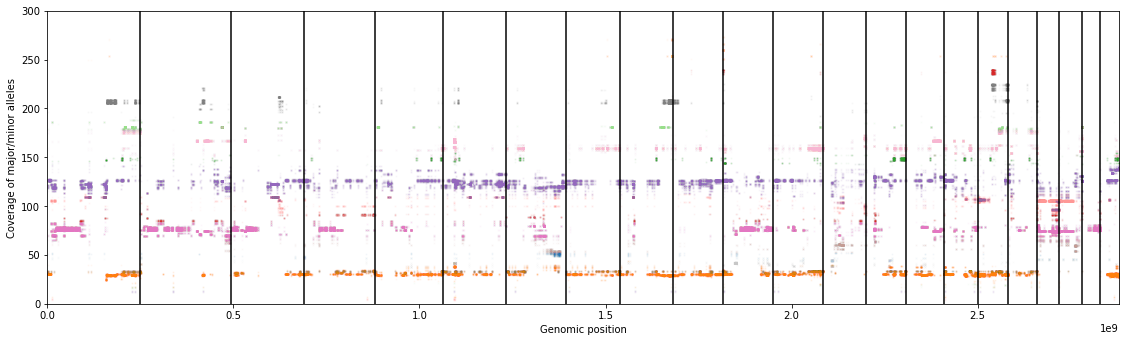

In [35]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [36]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [37]:
a_cov_dp.run(1)

n unassigned: 1547
n unassigned: 1445
n unassigned: 1335
n unassigned: 1231
n unassigned: 1140
n unassigned: 1030
n unassigned: 949
n unassigned: 875
n unassigned: 805
n unassigned: 743
n unassigned: 694
n unassigned: 635
n unassigned: 591
n unassigned: 547
n unassigned: 511
n unassigned: 469
n unassigned: 419
n unassigned: 389
n unassigned: 360
n unassigned: 337
n unassigned: 307
n unassigned: 284
n unassigned: 266
n unassigned: 241
n unassigned: 222
n unassigned: 202
n unassigned: 190
n unassigned: 170
n unassigned: 162
n unassigned: 103
n unassigned: 47
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([ 0,  0,  0, ..., 25, 25, 25])],
 SortedDict({0: 64, 1: 90, 2: 246, 3: 114, 4: 15, 5: 46, 6: 61, 7: 23, 9: 132, 10: 30, 11: 296, 12: 161, 13: 7, 14: 63, 15: 60, 16: 72, 19: 13, 20: 10, 22: 15, 24: 8, 25: 13, 28: 4, 29: 5, 30: 1}))

In [38]:
a_cov_dp.ML_total_history[-1]

-4807.851369272

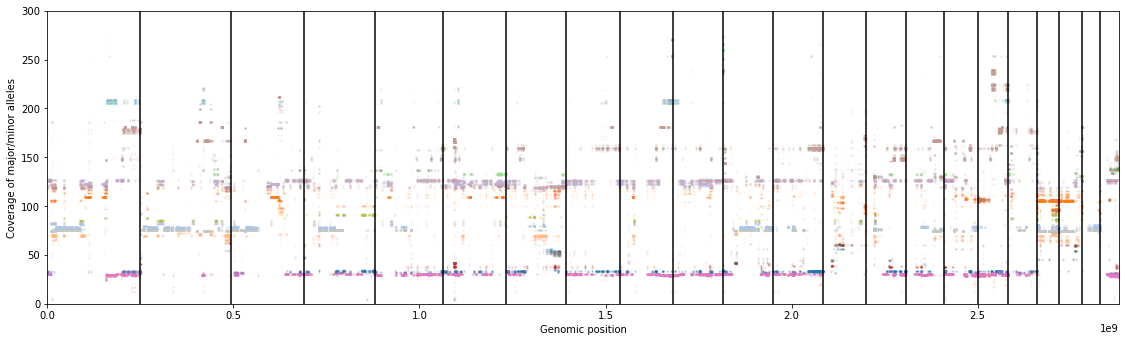

In [39]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

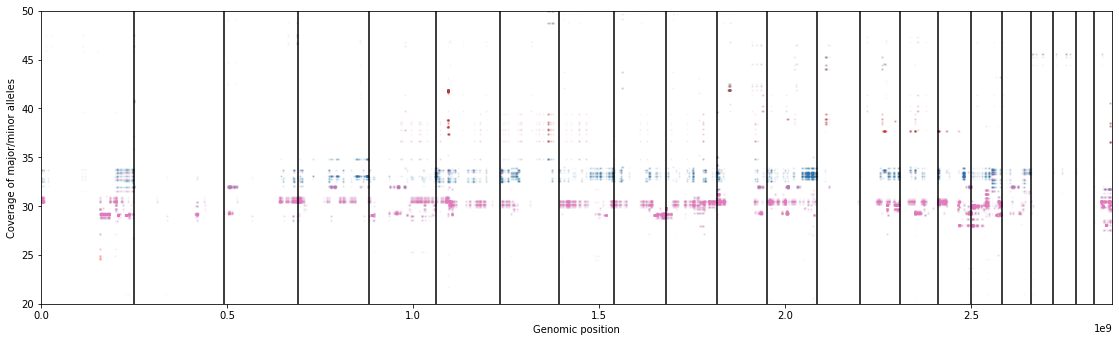

In [40]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([20, 50]);

In [45]:
[k for k in a_cov_dp.cluster_dict]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 19,
 20,
 22,
 24,
 25,
 28,
 29,
 30]

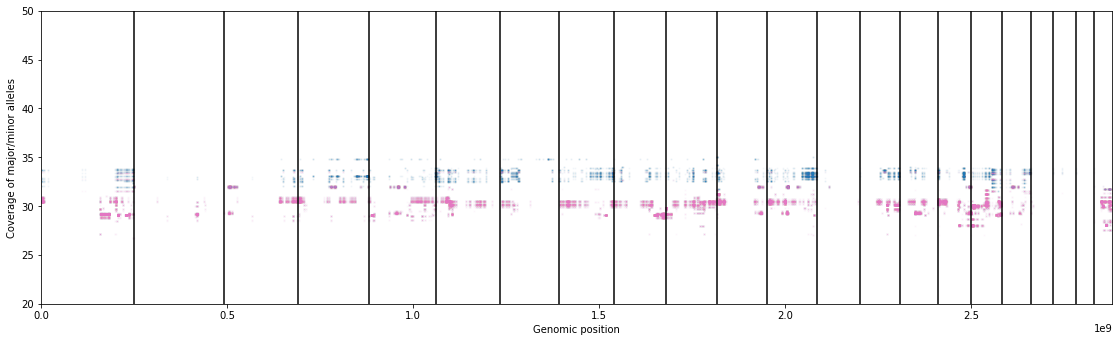

In [48]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in [0,12]:
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([20, 50]);

In [49]:
c0 = pd.DataFrame()
for s in a_cov_dp.cluster_dict[0]:
    c0 = c0.append(full_df[s][1])

In [54]:
c12 = pd.DataFrame()
for s in a_cov_dp.cluster_dict[12]:
    c12 = c12.append(full_df[s][1])

In [51]:
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
a_dict = {}
for name, x in full_df:
    maj_count, min_count = x.maj_count.sum(), x.min_count.sum()
    tuple_len = len(x)
    if name[2] == 1:
        f = x.maj_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    else:
        f =x.min_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    a_dict[name] = (maj_count, min_count, f, tuple_len)
    
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

def _tst_fun(x):
    name = (x.allelic_cluster.values[0], x.cov_DP_cluster.values[0], x.allele.values[0],x.dp_draw.values[0])

    maj_count, min_count, f, tup_len = a_dict[name]
    if tup_len < 10:
        maj_count, min_count = ADP_dict[name[0]]
        if name[2] == -1:
            f = min_count / (min_count+maj_count)
        else:
            f = maj_count / (min_count+maj_count)
    num_bins = len(x)
    return pd.Series({'DP_mu':np.exp(x.cov_DP_mu.values[0]), 'tup_maj_count':maj_count,  'tup_min_count':min_count, 'tup_len':tup_len, 'num_bins':num_bins, 'f':f,'mu*f':np.exp(x.cov_DP_mu.values[0]) * f})

In [55]:
#blue
c0.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     0        212.526927   35992.172785   
                                      1        210.307872   75500.935633   
                                      2        211.009125   62067.287622   
                                      3        212.868444   35112.923483   
                                      4        211.342722   59141.153363   
                                      6        209.138849   74156.235102   
                                      9        210.679979   67198.001097   
                1              -1     0        195.436534  171891.546782   
                                      1        192.658272  131954.528561   
                                      2        192.866449  143908.816572   
                                      3        192.963525  155981.886024   
                                      4        192.761560  145124.097204   
                                      5        192.658272  131954.528561   
                                      6        190.248239  141036.795107   
                                      7        190.185993  146371.243752   
                                      8        192.959406  134130.325527   
                                      9        192.629241  132197.408561   
                8              -1     3        221.242306   14881.294687   
                22             -1     4        199.064159  465060.978739   
1               5              -1     1        107.941537   31166.247452   
                                      3        107.544404   29380.057111   
                                      6        107.967476   32481.414784   
                21             -1     9        117.650704    1965.892465   
3               4              -1     5        161.823181  946026.383462   
                                      7        179.289089    4819.475423   
                7              -1     3        169.065300   24528.058349   
5               21             -1     2         66.713134  428239.289087   
                                1     2         66.713134  428239.289087   
                                      3         66.713134  428239.289087   
                                      5         66.713134  428239.289087   
6               1              -1     0        191.379909   13969.449173   
                                      7        195.363179    7035.903436   
                                      9        189.272378   16366.729450   
                4              -1     8        191.204223   15228.974255   
                11             -1     0        293.294894   10422.988493   
                                      1        293.294894   10422.988493   
                                      2        293.294894   10422.988493   
                                      3        294.579134   12246.248999   
                                      4        301.096884   14205.848999   
                                      7        283.547269   15339.868340   
                12             -1     7        165.346911    7624.040300   
9               6              -1     0        134.503885   28989.811217   
                                      1        134.503885   28989.811217   
                                      2        123.740713   10998.551349   
                                      3        125.136049   12962.321538   
                                      4        123.740713   10998.551349   
                                      5        123.740713   10998.551349   
                                      6        123.740713   10998.551349   
                                      7        124.781702   14280.622828   
                                      8        123.740713   10998.551349   
                                      9        123.740713   10998.551349   
11              3       

In [56]:
#blue
c12.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     5        211.905594   60852.006991   
                                      7        210.759894   68821.786457   
                                      8        206.968193   67875.371563   
                3              -1     0        165.622223   24320.534505   
                                      1        165.979178   15666.523332   
                                      2        165.773949   24748.789878   
                                      3        165.979178   15666.523332   
                                      4        165.979178   15666.523332   
                7              -1     1        165.545398    9082.266546   
                                      3        165.545398    9082.266546   
                                      5        175.884842   28836.091975   
                                      6        166.229024   15531.863864   
                                      7        166.229024   15531.863864   
                                      8        166.229024   15531.863864   
                                      9        169.175862   25975.214808   
                12             -1     4        165.545398    9082.266546   
                                      5        165.545398    9082.266546   
                                      8        165.220028    8839.386546   
                22             -1     3        159.045559  465060.978739   
                                      5        158.931541  465060.978739   
                25             -1     6        180.793701  465060.978739   
                                      8        194.963914  465060.978739   
1               5              -1     0        107.941537   31166.247452   
                                      2        107.546749   29736.577212   
                                      4        107.967476   32481.414784   
                                      5        107.588342   31051.744544   
                                      7        107.967476   32481.414784   
                                      8        107.985827   30379.051447   
                                      9        107.985827   30379.051447   
3               3              -1     0        156.373378  420854.063346   
                                      1        156.632852  405540.170506   
                                      2        156.993136  408757.641125   
                                      3        156.879981  312778.211949   
                                      4        155.829060  289859.992942   
                                      5        155.861482  271507.492011   
                                      6        153.154733  170397.209234   
                                      7        153.196975  108359.804902   
                                      8        153.196975  108359.804902   
                                      9        153.196975  108359.804902   
                4              -1     0        151.277241    3915.937522   
                                      1        151.277241    3915.937522   
                                      2        151.277241    3915.937522   
                                      3        158.812460   12645.374560   
                                      4        157.152202    3324.377522   
                                      6        140.622654    9140.794310   
                                      8        167.317566    2729.235423   
                                      9        157.540624    6354.299190   
                6              -1     0        135.684316   19545.274786   
                                      1        135.684316   19545.274786   
                                      2        135.684316   19545.274786   
                                      3        137.056204   25538.170588   
                        

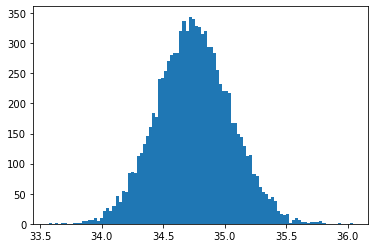

In [68]:
#ADP 0, CDP 11
_ =plt.hist(np.exp(stats.norm.rvs(4.901, 0.000306, size=10000)) * (stats.beta.rvs(10109,28989, size=10000)), bins = 100)

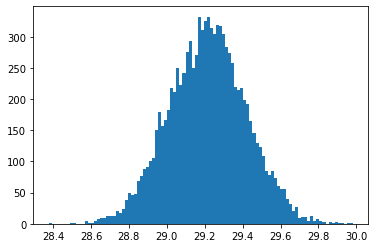

In [547]:
_ =plt.hist(np.exp(stats.norm.rvs(4.68, 0.000196, size=10000)) * (stats.beta.rvs(15053,40473, size=10000)), bins = 100)

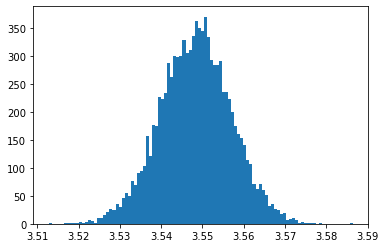

In [551]:
_ =plt.hist((stats.norm.rvs(4.901, 0.000306, size=10000) + np.log(stats.beta.rvs(10109,28989, size=10000))), bins = 100)

In [62]:
c0.loc[(c0.allelic_cluster==9) & (c0.allele==-1) & (c0.dp_draw==0)].sum()

chr                          821
start                16981921077
end                  16981992601
covcorr                 17017996
covraw                  25868869
start_g             158880575930
end_g               158880647454
C_len                      71665
C_RT                  115.053978
C_RT_z                -41.936901
C_GC                   68.955437
C_GC_z                 -1.402215
allelic_cluster             1269
segment_ID                 14739
min_count           10109.905712
maj_count           28989.811217
cov_DP_cluster               846
cov_DP_mu             691.124625
cov_DP_sigma            0.043157
next_g              158960900208
allele                      -141
a_cov_segID                61217
seg_min_count       65613.333309
seg_maj_count      182739.186744
dp_draw                        0
dtype: object

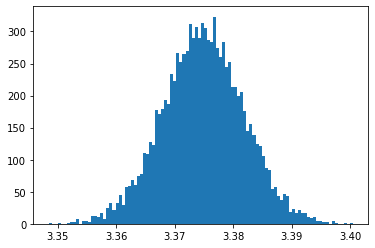

In [549]:
_ =plt.hist((stats.norm.rvs(4.68, 0.000196, size=10000) + np.log(stats.beta.rvs(15053,40473, size=10000))), bins = 100)

In [69]:
c12.loc[(c12.allelic_cluster==9) & (c12.allele==-1) & (c12.dp_draw==0)].sum()

chr                         3118
start                15577768869
end                  15577860609
covcorr                 21215935
covraw                  32478203
start_g             501871615714
end_g               501871707454
C_len                      91992
C_RT                  220.559206
C_RT_z                 61.442233
C_GC                  140.014206
C_GC_z                 23.302452
allelic_cluster             2268
segment_ID                 27027
min_count           15053.060654
maj_count           40473.265979
cov_DP_cluster              1260
cov_DP_mu            1179.812321
cov_DP_sigma            0.049296
next_g              501929110870
allele                      -252
a_cov_segID               207824
seg_min_count      198099.542889
seg_maj_count      530093.019848
dp_draw                        0
dtype: object

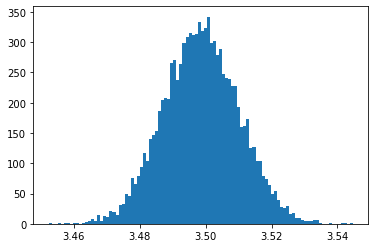

In [764]:
#seg 0
_ =plt.hist((stats.norm.rvs(5.359069, 0.000462, size=10000) + np.log(stats.beta.rvs(6632,35992, size=10000))), bins = 100)

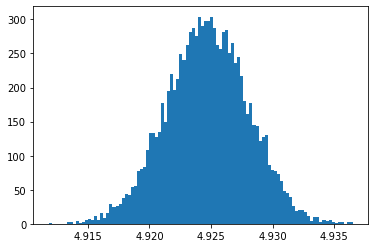

In [778]:
#seg50
_ =plt.hist((stats.norm.rvs(5.111862, 0.000386, size=10000) + np.log(stats.beta.rvs(15666,3224, size=10000))), bins = 100)

In [767]:
5.359069 + np.log(6632/ (6632+35992))

3.49855794291507

In [768]:
5.275236 + np.log(35277/ (35277+171891))

3.504937135205609

trying with values in log space

In [972]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [973]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [941]:
full_df[50][1].sum()

chr                         1077
start                 2236771412
end                   2236790786
covcorr                  7817089
covraw                  11892006
start_g             140845348797
end_g               140845368171
C_len                      19423
C_RT                   48.518891
C_RT_z                 59.157311
C_GC                   29.799737
C_GC_z                  8.367228
allelic_cluster                0
segment_ID                   343
min_count            3224.115853
maj_count           15666.523332
cov_DP_cluster               147
cov_DP_mu             250.481255
cov_DP_sigma            0.018893
next_g              140866495317
allele                        49
a_cov_segID               667980
seg_min_count       51173.225296
seg_maj_count      246413.656162
dp_draw                      196
dtype: object

In [924]:
np.array([s for s in a_cov_dp.segment_r_list])[:50]

array([3.49862333, 3.51822476, 3.48538188, 3.47801668, 3.46335424,
       3.48906508, 3.52015539, 3.50831299, 3.45301985, 3.51020496,
       5.18993581, 5.17379309, 5.1838838 , 5.19558138, 5.18972299,
       5.18822503, 5.16677924, 5.17822671, 5.16691246, 5.17741929,
       3.50493523, 3.5004081 , 3.51012632, 3.50938975, 3.50889384,
       3.5004081 , 3.48906318, 3.49479551, 3.52239859, 3.50023941,
       5.08856652, 5.07222762, 5.07150432, 5.07226749, 5.07110474,
       5.07222762, 5.05938096, 5.05778883, 5.06949425, 5.07208066,
       3.35183199, 3.34385458, 3.35248176, 3.34385458, 3.34385458,
       3.23203296, 4.9204715 , 4.92472199, 4.92144256, 4.92472199])

In [931]:
self=a_cov_dp
segID = 30

# get cluster assignment of S
clustID = self.cluster_assignments[segID]
# print('seg_pick:', segID, clustID)
# compute ML of AB = Cs (cached)
if clustID == -1:
    ML_AB = 0
else:
    ML_AB = self.cluster_MLs[clustID]

# compute ML of A = Cs - S
if clustID == -1:
    ML_A = 0
# if cluster is empty without S ML is also 0
elif self.cluster_counts[clustID] == 1:
    ML_A = 0
else:
    ML_A = self._ML_cluster(self.cluster_dict[clustID].difference([segID]))

# compute ML of S on its own
ML_S = self._ML_cluster([segID])

# compute ML of every other cluster C = Ck, k != s (cached)
# for now were also allowing it to chose to stay in current cluster

ML_C = np.array([ML for (ID, ML) in self.cluster_MLs.items()])

# compute ML of every cluster if S joins
ML_BC = np.array([self._ML_cluster(self.cluster_dict[k].union([segID]))
                  for k in self.cluster_counts.keys()])
# likelihood ratios of S joining each other cluster S -> Ck
ML_rat_BC = ML_A + ML_BC - (ML_AB + ML_C)

# if cluster is unassigned we set the ML ratio to 1 for staying in its own cluster
# print(ML_rat_BC)
if clustID > -1:
    ML_rat_BC[list(self.cluster_counts.keys()).index(clustID)] = 0

# compute ML of S starting a new cluster
ML_new = ML_A + ML_S - ML_AB

ML_rat = np.r_[ML_rat_BC, ML_new]

prior_diff = []
clust_prior_p = 1
# use prior cluster information if available

count_prior = np.r_[
    [count_prior[self.prior_clusters.index(x)] for x in
     prior_diff], self.cluster_counts.values(), self.alpha]
count_prior /= count_prior.sum()

# if self.prior_clusters:
# print('count prior: ', count_prior)
# construct transition probability distribution and draw from it
MLs_max = ML_rat.max()
choice_p = np.exp(ML_rat - MLs_max + np.log(count_prior) + np.log(clust_prior_p)) / np.exp(
    ML_rat - MLs_max + np.log(count_prior) + np.log(clust_prior_p)).sum()

In [932]:
ML_BC

array([-53.13642996])

In [933]:
ML_new

-2.9319931833687005

In [934]:
ML_rat

array([-50.36020176,  -2.93199318])

In [907]:
self.cluster_counts

SortedDict({0: 1})

In [908]:
choice_p

array([1.49335224e-14, 1.00000000e+00])

In [896]:
ML_rat

array([-43.17277748, -20.54794997])

In [897]:
self.cluster_MLs

SortedDict({0: -20.39218498514744})

In [869]:
ML_new

-31.538088905853535

In [850]:
a_cov_dp._ML_cluster([0,50])

-72.48112339469716

In [851]:
a_cov_dp._ML_cluster([0]) + a_cov_dp._ML_cluster([50])

-63.95402497973719

In [1107]:
V_lst =[]
r_lst = []
for s in [0,2,3,4]:
    r_lst.append(a_cov_dp.segment_r_list[s])
    V_lst.append(a_cov_dp.segment_V_list[s])
V = np.hstack(V_lst)
r = np.hstack(r_lst)
V_resid = ((V - V.mean())**2).sum()
V_sum = (V**2).sum()

In [1108]:
r

array([3.49862333, 3.48538188, 3.47801668, 3.46335424])

In [1181]:
r_big = np.repeat(r,4)
a_cov_dp.ML_normalgamma(r_big, 1, 1e-30, alpha,beta)

4.037729944313865

In [1182]:
r_big = np.repeat(r,75)
a_cov_dp.ML_normalgamma(r_big, 1, 1e-30, alpha,beta)

813.4873960223257

In [1183]:
r_big = np.repeat(r,79)
a_cov_dp.ML_normalgamma(r_big, 1, 1e-30, alpha,beta)

860.1964574671294

In [1124]:
r_big = np.repeat(r,25)
a_cov_dp.ML_normalgamma(r_big, 1, 1e-30, alpha,beta)

234.88928485384457

In [1125]:
r_big = np.repeat(r,5)
a_cov_dp.ML_normalgamma(r_big, 1, 1e-30, alpha,beta)

14.337059972724727

In [1127]:
r_big = np.repeat(r,30)
a_cov_dp.ML_normalgamma(r_big, 1, 1e-30, alpha,beta)

291.89404995450536

In [1128]:
r_big.shape

(120,)

In [1083]:
V.mean()

-0.016412552015019167

In [1085]:
((r - r.mean())**2).sum()

0.001737732741270167

In [1086]:
V_sum / len(V)

0.033581892460482675

In [1087]:
V_resid/len(V)

0.03331252059683697

In [1088]:
alpha=10
beta = alpha/30 * V_sum / len(V)

In [1089]:
beta

0.011193964153494225

In [828]:
a_cov_dp.ML_normalgamma(r, 1, 1e-30, alpha,beta)

-72.48112339469716

In [835]:
a_cov_dp.ML_normalgamma(r, 1, 1e-30, alpha,beta)

-32.16052326200066

In [842]:
a_cov_dp.ML_normalgamma(r, 1, 1e-30, alpha,beta)

-31.793501717736532

In [974]:
a_cov_dp.run(1)

n unassigned: 1547
n unassigned: 1432
n unassigned: 1315
n unassigned: 1215
n unassigned: 1127
n unassigned: 1045
n unassigned: 964
n unassigned: 882
n unassigned: 799
n unassigned: 741
n unassigned: 673
n unassigned: 617
n unassigned: 563
n unassigned: 509
n unassigned: 481
n unassigned: 450
n unassigned: 417
n unassigned: 382
n unassigned: 353
n unassigned: 326
n unassigned: 298
n unassigned: 279
n unassigned: 267
n unassigned: 249
n unassigned: 233
n unassigned: 217
n unassigned: 194
n unassigned: 182
n unassigned: 170
n unassigned: 160
n unassigned: 113
n unassigned: 46
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([0, 0, 0, ..., 8, 8, 8])],
 SortedDict({0: 226, 1: 203, 2: 46, 3: 33, 5: 131, 6: 11, 7: 34, 8: 25, 9: 118, 10: 408, 11: 79, 12: 45, 13: 145, 15: 8, 16: 31, 18: 6}))

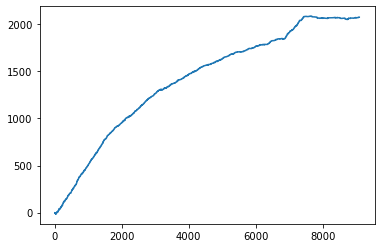

In [943]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)],a_cov_dp.ML_total_history)

In [975]:
a_cov_dp.ML_total_history[-1]

1693.574890115806

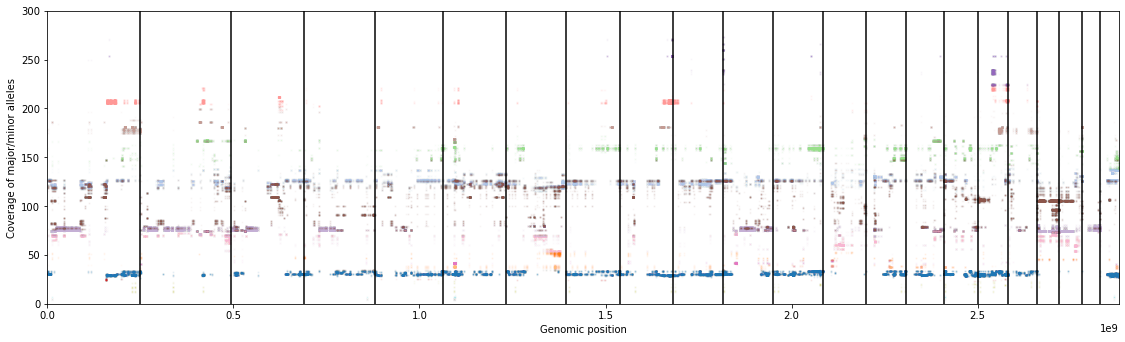

In [976]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

n unassigned: 1547
n unassigned: 1429
n unassigned: 1322
n unassigned: 1231
n unassigned: 1136
n unassigned: 1041
n unassigned: 961
n unassigned: 884
n unassigned: 813
n unassigned: 758
n unassigned: 695
n unassigned: 644
n unassigned: 587
n unassigned: 543
n unassigned: 496
n unassigned: 454
n unassigned: 426
n unassigned: 396
n unassigned: 361
n unassigned: 332
n unassigned: 300
n unassigned: 281
n unassigned: 259
n unassigned: 231
n unassigned: 212
n unassigned: 199
n unassigned: 185
n unassigned: 171
n unassigned: 165
n unassigned: 118
n unassigned: 62
n unassigned: 7
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 1547
n unassigned: 1422
n unassigned: 1302
n unassigned: 1202
n unassigned: 1106
n unassigned: 1017
n unassigned: 937
n unassigned: 852
n unassigned: 782
n unassigned: 715
n unassigned: 657
n unassigned: 606
n unassigned: 555
n unassigned: 502
n unassigned: 461
n unassigned: 419
n unassigned: 390
n unas

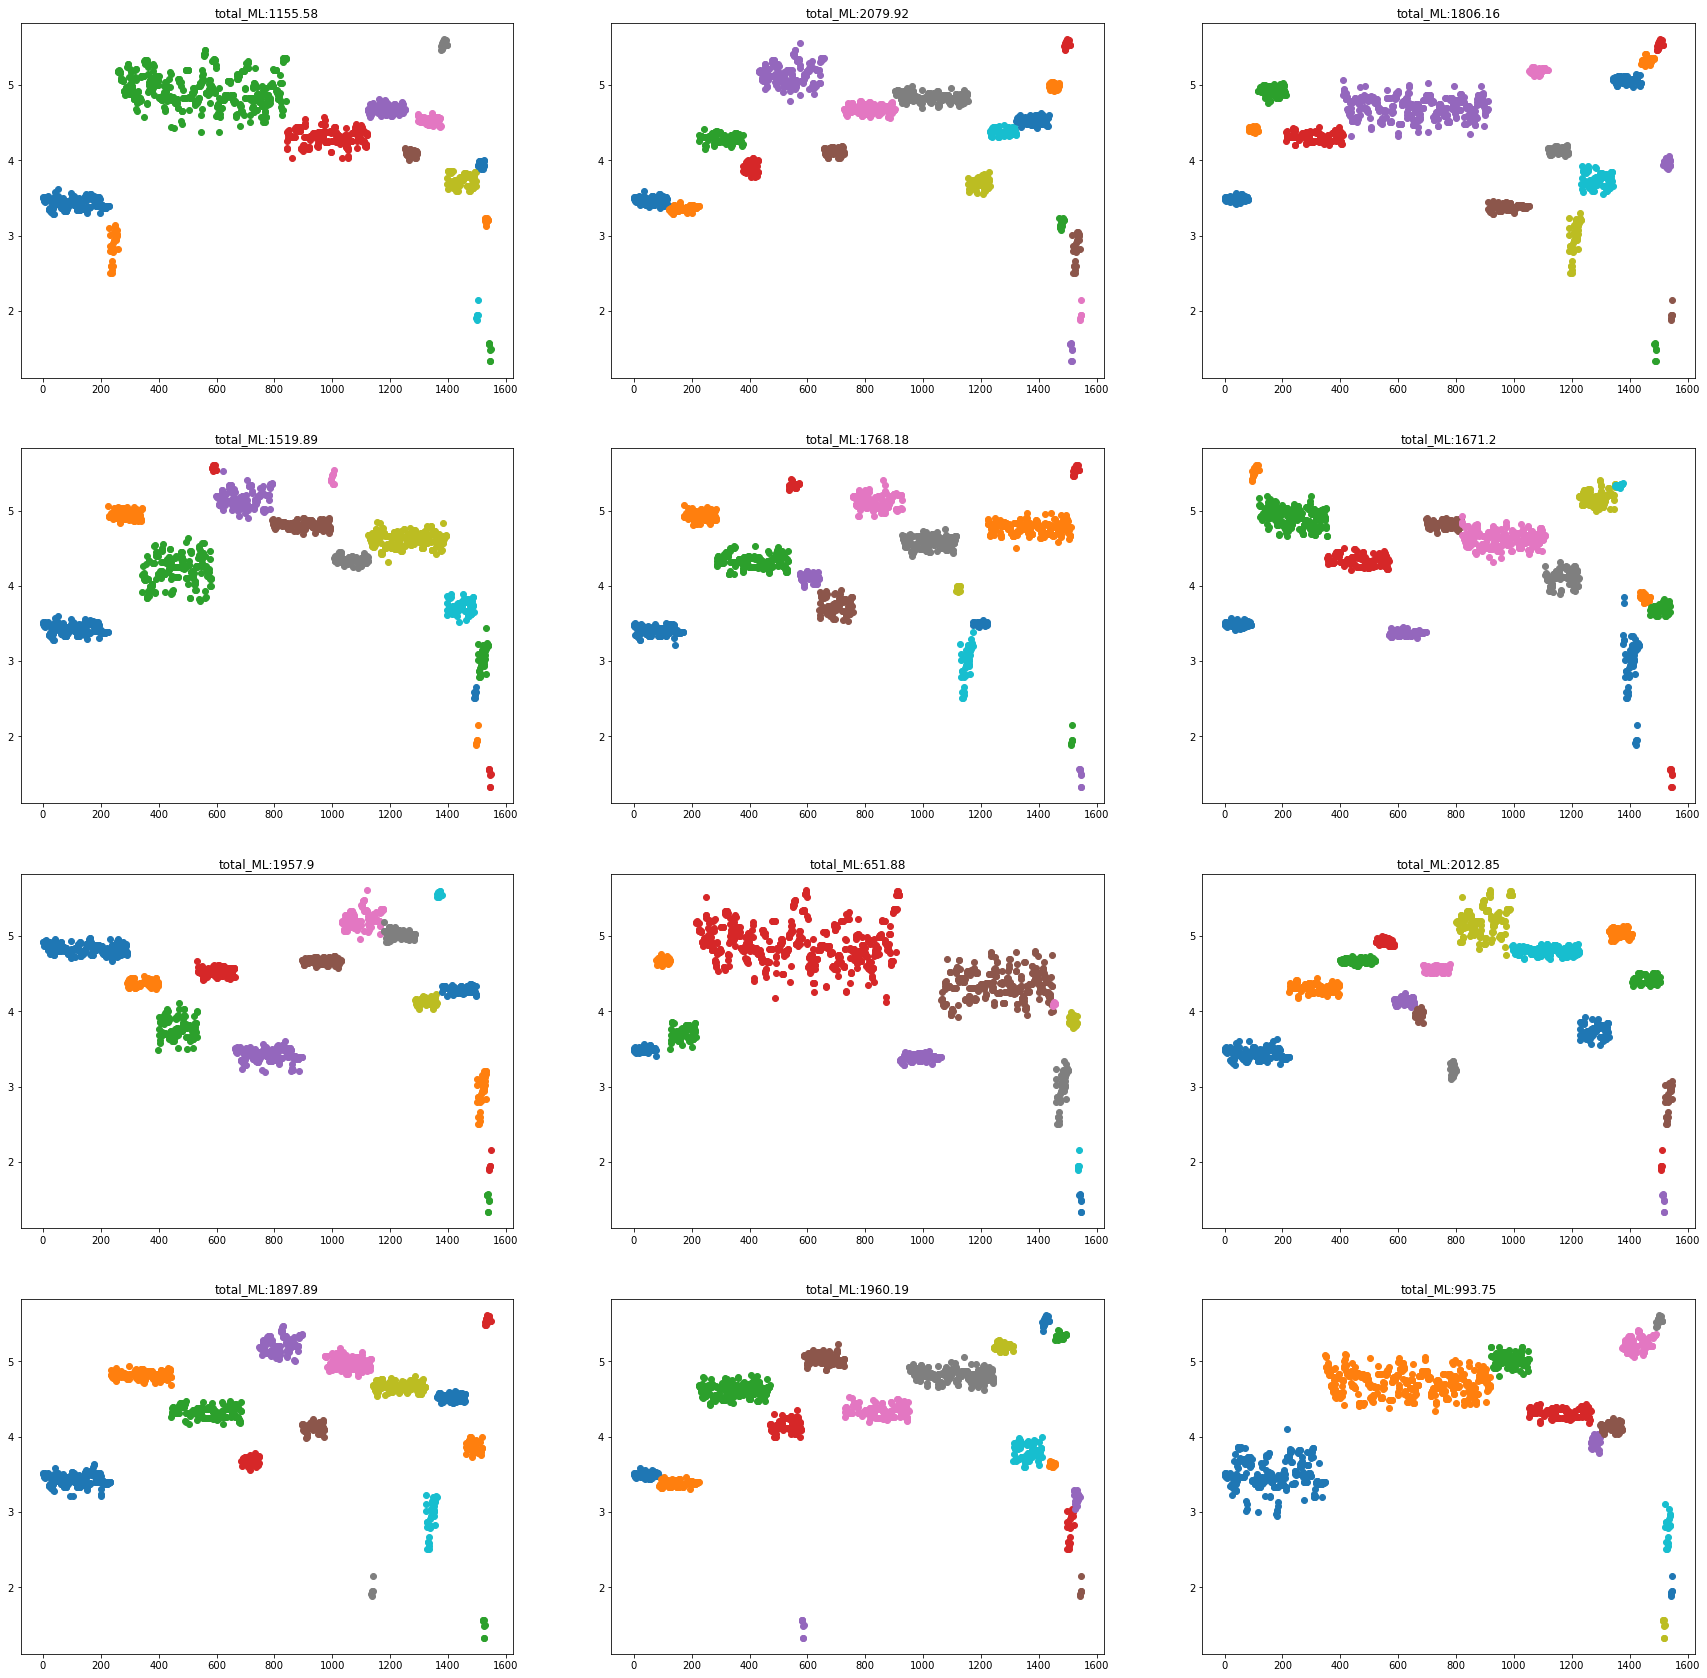

In [992]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [993]:
a_cov_dp = best_a_cov_dp

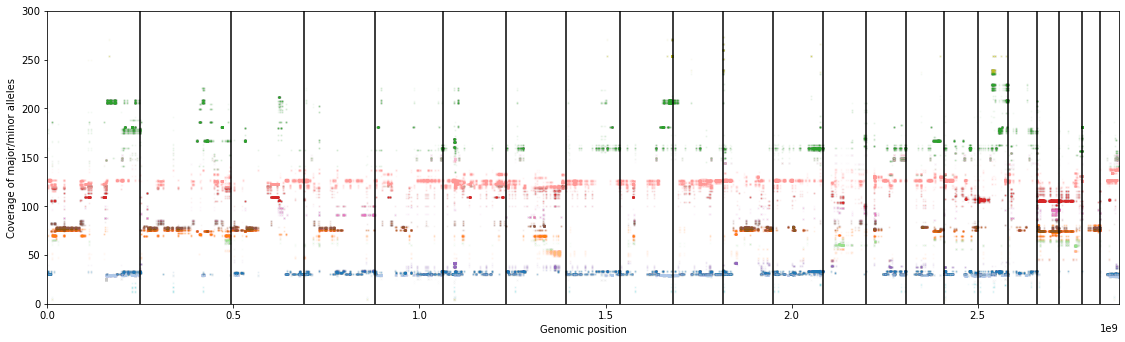

In [994]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [1060]:
def DP_prior(M, N, nc, alpha):
    return np.exp(sum([np.log(nc + i) for i in range(M)]) - sum([np.log(N + alpha -i) for i in np.r_[1:M+1]]))

In [1104]:
def DP_prior(M, N, nc, alpha):
    return ss.loggamma(M + nc) + ss.loggamma(N + alpha - M) - (ss.loggamma(nc) + ss.loggamma(N + alpha))

In [1067]:
#consider an example with cluster one having 20 datapoints, cluster 2 having 5 datapoings and cluster 3 having 40 datapoints

In [1066]:
#prior prob merging cluster 1 with cluster 3
DP_prior(20, 65, 40, 0.4)

0.12285246063915166

In [1065]:
#prior prob merging cluster 1 with cluster 2
DP_prior(20, 65, 5, 0.4)

4.671321580310479e-13

In [1021]:
# proposing merging cluster 1 with itself
DP_prior(20, 65, 0.4, 0.4)

3.264745478801605e-18

In [1068]:
#cluster remaining by itself
1- (DP_prior(20, 65, 5, 0.4) + DP_prior(20, 65, 40, 0.4))

0.8771475393603813

In [1066]:
#prior prob merging cluster 1 with cluster 3
DP_prior(20, 65, 40, 0.4)

0.12285246063915166

In [1139]:
#prior prob merging cluster 1 with cluster 2
DP_prior(10, 1500, 50, 0.4)

-33.130042565750045

In [1173]:
a_cov_dp.cluster_counts

SortedDict({0: 123, 1: 104, 2: 152, 3: 54, 4: 225, 5: 70, 6: 176, 7: 252, 8: 76, 10: 91, 12: 113, 13: 36, 15: 17, 16: 20, 17: 8, 18: 26, 19: 6})

In [1178]:
def DP_merge_prior(self, cur_index):
    cluster_vals = np.array(self.cluster_counts.values())
    N = cluster_vals.sum()
    M = cluster_vals[cur_index]
    prior_results = np.zeros(len(cluster_vals))
    for i, nc in enumerate(cluster_vals):
        if i != cur_index:
            prior_results[i] = ss.loggamma(M + nc) + ss.loggamma(N + self.alpha - M) - (ss.loggamma(nc) + ss.loggamma(N + self.alpha))
    prior_results[cur_index] = np.log(1-np.exp(dp_cov.LSE(prior_results[prior_results != 0])))
    return prior_results

In [1180]:
DP_merge_prior(a_cov_dp, 11)

array([ -86.08294236,  -91.34706763,  -79.29665734, -110.68981975,
        -66.36854676, -103.28952068,  -74.51354592,  -62.56184029,
       -100.86961697,  -95.45489997,  -88.75680283,    0.        ,
       -138.32254529, -135.02396022, -151.00360133, -129.27607942,
       -154.76480145])

running with new merge prior

In [1205]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [1206]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)

In [1207]:
a_cov_dp.run(1)

n unassigned: 1547
cluster 5 merging with 3
cluster 10 merging with 0
n unassigned: 1422
cluster 15 merging with 7
cluster 17 merging with 7
n unassigned: 1317
n unassigned: 1194
n unassigned: 1082
n unassigned: 1003
n unassigned: 928
cluster 19 merging with 9
n unassigned: 848
n unassigned: 776
n unassigned: 711
n unassigned: 656
n unassigned: 611
n unassigned: 563
n unassigned: 506
n unassigned: 471
n unassigned: 442
n unassigned: 412
n unassigned: 385
n unassigned: 358
cluster 21 merging with 0
n unassigned: 325
n unassigned: 296
n unassigned: 272
n unassigned: 245
cluster 22 merging with 1
cluster 23 merging with 5
n unassigned: 228
n unassigned: 211
n unassigned: 197
cluster 24 merging with 14
n unassigned: 184
n unassigned: 165
n unassigned: 128
n unassigned: 57
cluster 25 merging with 8
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
cluster 26 merging with 9
n unassigned: 0
n unassigned: 0


([array([0, 0, 0, ..., 9, 9, 9])],
 SortedDict({0: 230, 1: 236, 2: 59, 4: 173, 5: 243, 6: 123, 7: 160, 8: 102, 9: 23, 11: 33, 12: 28, 13: 74, 14: 41, 16: 10, 18: 8, 20: 6}))

In [1208]:
len(a_cov_dp.cluster_dict)

16

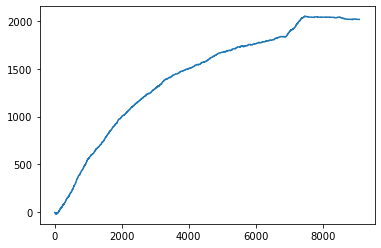

In [1209]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)],a_cov_dp.ML_total_history)

In [1210]:
a_cov_dp.ML_total_history[-1]

2016.5606207918536

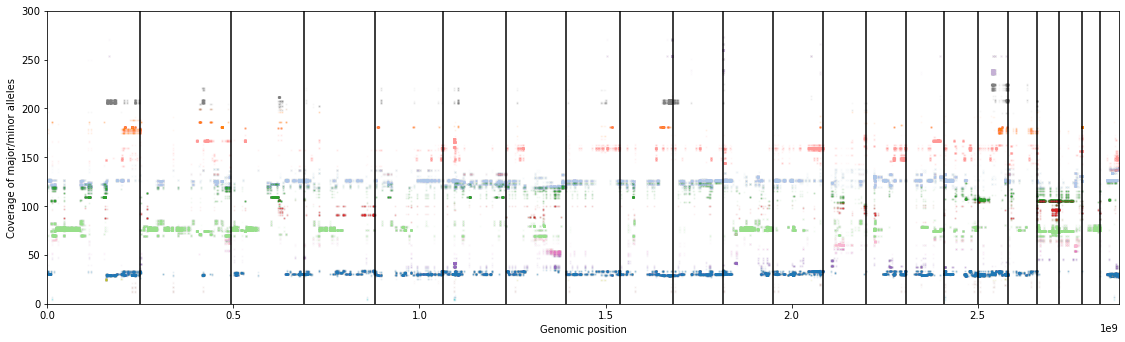

In [1211]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

n unassigned: 1547
cluster 6 merging with 1
cluster 4 merging with 6
cluster 14 merging with 0
n unassigned: 1411
cluster 17 merging with 3
n unassigned: 1306
cluster 10 merging with 14
n unassigned: 1208
n unassigned: 1110
n unassigned: 1021
n unassigned: 933
cluster 19 merging with 8
n unassigned: 862
n unassigned: 783
n unassigned: 716
n unassigned: 659
n unassigned: 616
n unassigned: 569
n unassigned: 525
n unassigned: 476
n unassigned: 439
n unassigned: 406
n unassigned: 371
n unassigned: 350
n unassigned: 317
n unassigned: 298
n unassigned: 274
n unassigned: 264
n unassigned: 243
n unassigned: 229
n unassigned: 209
n unassigned: 192
n unassigned: 178
n unassigned: 164
n unassigned: 139
n unassigned: 74
n unassigned: 16
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 1547
cluster 15 merging with 8
cluster 12 merging with 8
cluster 16 merging with 13
n unassigned: 1416
cluster 19 merging with 6
cluster 21 merging 

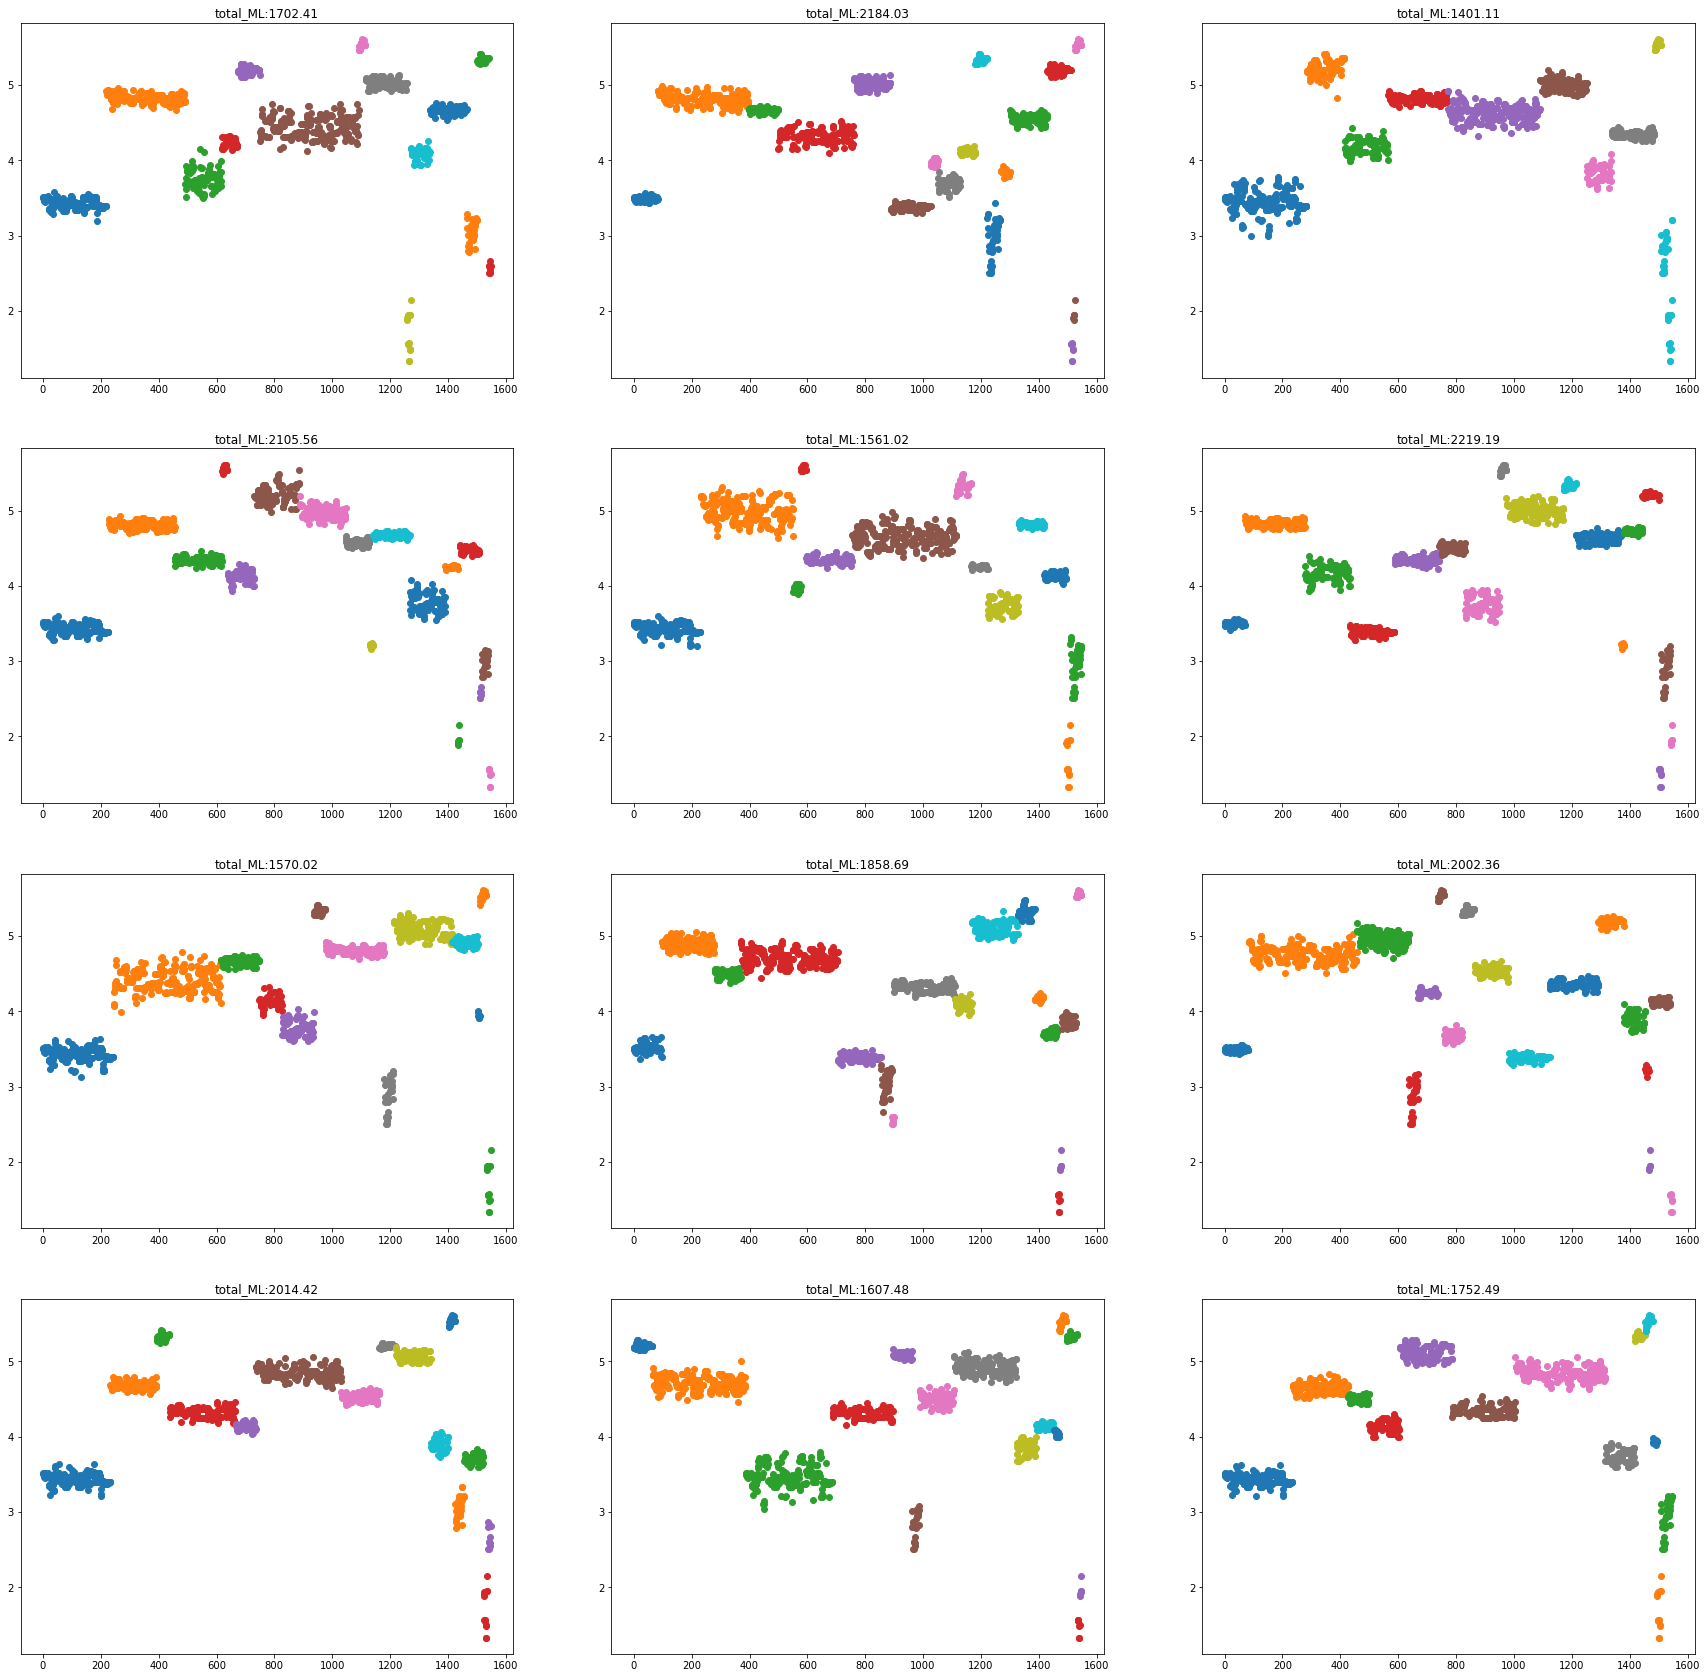

In [1212]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [1213]:
a_cov_dp = best_a_cov_dp

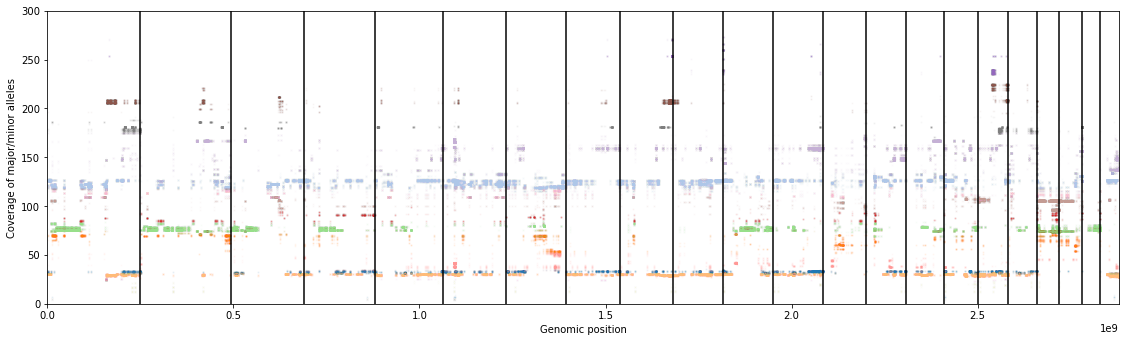

In [1214]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);